In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2022-06-21 14:12:26.888532: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


In [2]:
# !pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.5.0


In [4]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [5]:

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [50]:
gz

'/home/reshad812/.keras/datasets/HIGGS.csv.gz'

In [7]:
FEATURES = 28

In [8]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

2022-06-21 14:12:28.550005: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-21 14:12:28.580963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-06-21 14:12:28.581046: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-21 14:12:28.587830: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-21 14:12:28.587966: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-06-21 14:12:28.589273: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10

In [51]:
ds

<CsvDatasetV2 shapes: ((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [9]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

2022-06-21 14:12:29.253814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-21 14:12:29.272915: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


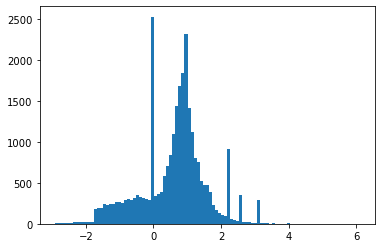

In [10]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [52]:
packed_ds

<_UnbatchDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [12]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [53]:
validate_ds

<BatchDataset shapes: ((None, 28), (None,)), types: (tf.float32, tf.float32)>

# demonstrate overfit

In [15]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

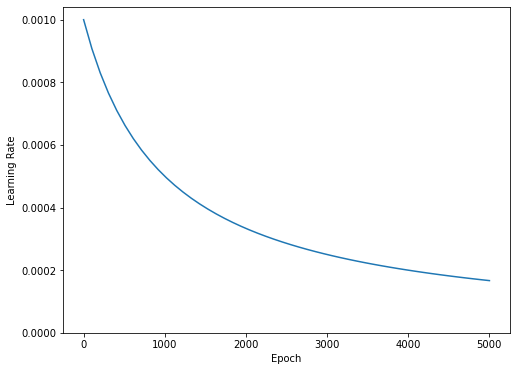

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [17]:
def get_callbacks(name):
    return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [18]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[
              tf.keras.losses.BinaryCrossentropy(
                  from_logits=True, name='binary_crossentropy'),
              'accuracy'])

    model.summary()

    history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
    
    return history

# the tiny model

In [19]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [20]:
size_histories = {}

In [21]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


2022-06-21 14:12:32.678731: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 14:12:32.678789: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 14:12:32.718368: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-06-21 14:12:32.729922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-06-21 14:12:32.804566: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-06-21 14:12:32.916274: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


2022-06-21 14:12:36.535172: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp68fgim69/tensorboard_logs/sizes/Tiny/train/plugins/profile/2022_06_21_14_12_36
2022-06-21 14:12:36.542180: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmp68fgim69/tensorboard_logs/sizes/Tiny/train/plugins/profile/2022_06_21_14_12_36/Galileo.trace.json.gz
2022-06-21 14:12:36.599661: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp68fgim69/tensorboard_logs/sizes/Tiny/train/plugins/profile/2022_06_21_14_12_36
2022-06-21 14:12:36.601349: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /tmp/tmp68fgim69/tensorboard_logs/sizes/Tiny/train/plugins/profile/2022_06_21_14_12_36/Galileo.memory_profile.json.gz
2022-06-21 14:12:36.601825: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: 


Epoch: 0, accuracy:0.4794,  binary_crossentropy:0.8013,  loss:0.8013,  val_accuracy:0.4720,  val_binary_crossentropy:0.7772,  val_loss:0.7772,  
....................................................................................................
Epoch: 100, accuracy:0.6084,  binary_crossentropy:0.6240,  loss:0.6240,  val_accuracy:0.5990,  val_binary_crossentropy:0.6166,  val_loss:0.6166,  
....................................................................................................
Epoch: 200, accuracy:0.6275,  binary_crossentropy:0.6101,  loss:0.6101,  val_accuracy:0.6100,  val_binary_crossentropy:0.6012,  val_loss:0.6012,  
....................................................................................................
Epoch: 300, accuracy:0.6450,  binary_crossentropy:0.5999,  loss:0.5999,  val_accuracy:0.6310,  val_binary_crossentropy:0.5908,  val_loss:0.5908,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

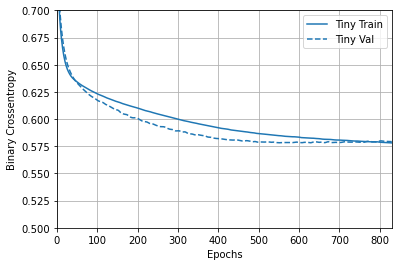

In [22]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

# add small model later

In [23]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [24]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


2022-06-21 14:28:32.213381: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 14:28:32.213428: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 14:28:32.213712: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 14:28:32.213749: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-06-21 14:28:32.572298: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 14:28:32.572324: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 14:28:32.572465: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 14:28:32.602695: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-21 14:28:32.605625: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-21 14:28:32.606943: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-21 14:28:32.617488: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp68fgim69/tensorboard_logs/sizes/Small/trai


Epoch: 0, accuracy:0.4715,  binary_crossentropy:0.8548,  loss:0.8548,  val_accuracy:0.4740,  val_binary_crossentropy:0.7557,  val_loss:0.7557,  
....................................................................................................
Epoch: 100, accuracy:0.6162,  binary_crossentropy:0.6176,  loss:0.6176,  val_accuracy:0.5990,  val_binary_crossentropy:0.6139,  val_loss:0.6139,  
....................................................................................................
Epoch: 200, accuracy:0.6562,  binary_crossentropy:0.5946,  loss:0.5946,  val_accuracy:0.6380,  val_binary_crossentropy:0.5876,  val_loss:0.5876,  
....................................................................................................
Epoch: 300, accuracy:0.6646,  binary_crossentropy:0.5802,  loss:0.5802,  val_accuracy:0.6730,  val_binary_crossentropy:0.5805,  val_loss:0.5805,  
....................................................................................................
Epoch: 40

In [26]:
# medium layer

In [25]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [27]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


2022-06-21 14:43:33.136275: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 14:43:33.136313: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 14:43:33.136617: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 14:43:33.136660: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-06-21 14:43:33.549409: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 14:43:33.549438: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 14:43:33.549601: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 14:43:33.587553: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-21 14:43:33.590631: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-21 14:43:33.592118: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-21 14:43:33.602002: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp68fgim69/tensorboard_logs/sizes/Medium/tra


Epoch: 0, accuracy:0.4687,  binary_crossentropy:0.7208,  loss:0.7208,  val_accuracy:0.4830,  val_binary_crossentropy:0.6910,  val_loss:0.6910,  
....................................................................................................
Epoch: 100, accuracy:0.7054,  binary_crossentropy:0.5373,  loss:0.5373,  val_accuracy:0.6600,  val_binary_crossentropy:0.6037,  val_loss:0.6037,  
....................................................................................................
Epoch: 200, accuracy:0.7776,  binary_crossentropy:0.4358,  loss:0.4358,  val_accuracy:0.6690,  val_binary_crossentropy:0.6685,  val_loss:0.6685,  
........................................................................

# large model

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


2022-06-21 14:51:43.435447: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 14:51:43.435485: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 14:51:43.435819: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 14:51:43.435856: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-06-21 14:51:43.851095: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 14:51:43.851122: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 14:51:43.851281: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 14:51:43.891502: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-21 14:51:43.894490: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-21 14:51:43.895903: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-21 14:51:43.906110: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp68fgim69/tensorboard_logs/sizes/large/trai


Epoch: 0, accuracy:0.5123,  binary_crossentropy:0.7767,  loss:0.7767,  val_accuracy:0.4690,  val_binary_crossentropy:0.6881,  val_loss:0.6881,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0023,  loss:0.0023,  val_accuracy:0.6480,  val_binary_crossentropy:1.8428,  val_loss:1.8428,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6560,  val_binary_crossentropy:2.5127,  val_loss:2.5127,  
.........................

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

In [32]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

In [33]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

In [34]:
display.IFrame(
    vocnet="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [35]:
tensorboard dev upload --logdir  {logdir}/sizes

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2022-06-21 15:02:14.638904: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/tmp/tmp68fgim69/tensorboard_logs/sizes

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Traceback (most recent call last):
  File "/home/reshad812/anaconda3/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/home/reshad812/anaconda3/

In [36]:
# preventing overfitting

In [37]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmp68fgim69/tensorboard_logs/regularizers/Tiny')

In [38]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [39]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


2022-06-21 15:08:06.686376: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 15:08:06.686404: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 15:08:06.686684: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 15:08:06.686749: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-06-21 15:08:07.169284: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 15:08:07.169309: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 15:08:07.169455: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 15:08:07.210045: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-21 15:08:07.214162: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-21 15:08:07.216024: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-21 15:08:07.226434: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp68fgim69/tensorboard_logs/regularizers/l2/


Epoch: 0, accuracy:0.4976,  binary_crossentropy:0.8092,  loss:2.3299,  val_accuracy:0.5770,  val_binary_crossentropy:0.6803,  val_loss:2.1257,  
....................................................................................................
Epoch: 100, accuracy:0.6535,  binary_crossentropy:0.5991,  loss:0.6208,  val_accuracy:0.6730,  val_binary_crossentropy:0.5889,  val_loss:0.6107,  
....................................................................................................
Epoch: 200, accuracy:0.6654,  binary_crossentropy:0.5857,  loss:0.6067,  val_accuracy:0.6590,  val_binary_crossentropy:0.5809,  val_loss:0.6020,  
....................................................................................................
Epoch: 300, accuracy:0.6733,  binary_crossentropy:0.5808,  loss:0.6051,  val_accuracy:0.6760,  val_binary_crossentropy:0.5767,  val_loss:0.6003,  
....................................................................................................
Epoch: 40

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

(0.5, 0.7)

In [41]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

In [42]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

2022-06-21 15:09:44.007107: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 15:09:44.007140: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 15:09:44.007297: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 15:09:44.007360: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-06-21 15:09:44.470930: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 15:09:44.470954: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 15:09:44.471088: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 15:09:44.530604: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-21 15:09:44.533844: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-21 15:09:44.535471: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-21 15:09:44.545584: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp68fgim69/tensorboard_logs/regularizers/dro


Epoch: 0, accuracy:0.5118,  binary_crossentropy:0.7843,  loss:0.7843,  val_accuracy:0.5560,  val_binary_crossentropy:0.6731,  val_loss:0.6731,  
....................................................................................................
Epoch: 100, accuracy:0.6538,  binary_crossentropy:0.5989,  loss:0.5989,  val_accuracy:0.6960,  val_binary_crossentropy:0.5909,  val_loss:0.5909,  
....................................................................................................
Epoch: 200, accuracy:0.6930,  binary_crossentropy:0.5547,  loss:0.5547,  val_accuracy:0.7000,  val_binary_crossentropy:0.5842,  val_loss:0.5842,  
....................................................................................................
Epoch: 300, accuracy:0.7232,  binary_crossentropy:0.5076,  loss:0.5076,  val_accuracy:0.6850,  val_binary_crossentropy:0.6094,  val_loss:0.6094,  
.........................

(0.5, 0.7)

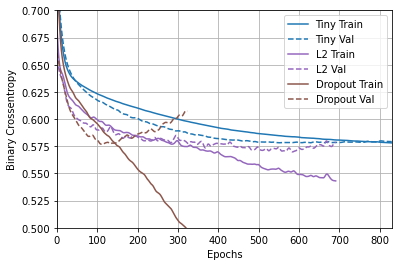

In [43]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [44]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

2022-06-21 15:10:31.686036: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 15:10:31.686060: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 15:10:31.686347: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 15:10:31.686520: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-06-21 15:10:32.199495: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-21 15:10:32.199519: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-21 15:10:32.199615: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-21 15:10:32.238012: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-21 15:10:32.241314: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-21 15:10:32.242844: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-21 15:10:32.253334: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp68fgim69/tensorboard_logs/regularizers/com


Epoch: 0, accuracy:0.5050,  binary_crossentropy:0.8107,  loss:0.9692,  val_accuracy:0.4600,  val_binary_crossentropy:0.7283,  val_loss:0.8860,  
....................................................................................................
Epoch: 100, accuracy:0.6434,  binary_crossentropy:0.6040,  loss:0.6336,  val_accuracy:0.6810,  val_binary_crossentropy:0.5842,  val_loss:0.6136,  
....................................................................................................
Epoch: 200, accuracy:0.6622,  binary_crossentropy:0.5898,  loss:0.6150,  val_accuracy:0.6850,  val_binary_crossentropy:0.5701,  val_loss:0.5953,  
....................................................................................................
Epoch: 300, accuracy:0.6697,  binary_crossentropy:0.5848,  loss:0.6130,  val_accuracy:0.6870,  val_binary_crossentropy:0.5618,  val_loss:0.5900,  
....................................................................................................
Epoch: 40

In [45]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

(0.5, 0.7)

In [46]:
%tensorboard --logdir {logdir}/regularizers

In [47]:
display.IFrame(
    vocnet="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

In [48]:
tensorboard dev upload --logdir  {logdir}/regularizers

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2022-06-21 15:13:25.074664: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/tmp/tmp68fgim69/tensorboard_logs/regularizers

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Traceback (most recent call last):
  File "/home/reshad812/anaconda3/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/home/reshad812/ana

In [49]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.//